## 车牌定位

In [35]:
import cv2
#import matplotlib.pyplot as plt
MAX_WIDTH = 500
Min_Area = 2000  #车牌区域允许最大面积
#加载图像
img = cv2.imread("./test/1.jpg")
cv2.imshow("img",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [36]:
pic_hight, pic_width = img.shape[:2]
pic_hight,pic_width

(4096, 2304)

In [37]:
#调整图像大小
resize_rate = MAX_WIDTH / pic_width
img = cv2.resize(img, (MAX_WIDTH, int(pic_hight*resize_rate)), interpolation=cv2.INTER_AREA)
cv2.imshow("img",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [38]:
#高斯去噪
img = cv2.GaussianBlur(img,(3,3),0)
cv2.imshow("img",img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [7]:
#保存旧的图像，便于以后操作
oldimg = img
#转化灰度图
img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
cv2.imshow("img",img)
cv2.waitKey(0)
cv2.destroyAllWindows()




In [8]:
import numpy as np

#去掉图像中不会是车牌的区域
kernel = np.ones((30, 30), np.uint8)
#形态学滤波（开运算，先腐蚀后膨胀）
img_opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
cv2.imshow("img_opening",img_opening)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
#图像加权
img_opening = cv2.addWeighted(img, 1, img_opening, -1, 0)
cv2.imshow("img_open",img_opening)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
# 边缘检测(找到图像边缘)
img_edge_canny = cv2.Canny(img_opening, 100, 200)
cv2.imshow("img_edge_canny",img_edge_canny)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
kernel = np.ones((4, 16))
# 闭运算，先进行膨胀然后进行腐蚀操作。通常是被用来填充前景物体中的小洞，或者抹去前景物体上的小黑点。因为可以想象，其就是先将白色部分变大，把小的黑色部分挤掉，然后再将一些大的黑色的部分还原回来，整体得到的效果就是：抹去前景物体上的小黑点了。
img_edge1_canny = cv2.morphologyEx(img_edge_canny, cv2.MORPH_CLOSE, kernel)

# 开运算（通过先进行腐蚀操作，再进行膨胀操作得到。移除小的对象时候很有用(假设物品是亮色，前景色是黑色)，被用来去除噪声。）
img_edge2_canny = cv2.morphologyEx(img_edge1_canny, cv2.MORPH_OPEN, kernel)
cv2.imshow("img_edge2_canny",img_edge2_canny)
cv2.waitKey(0)

-1

In [12]:
#查找图像边缘整体形成的矩形区域，可能有很多，车牌就在其中一个矩形区域中
try:
    contours, hierarchy = cv2.findContours(img_edge2_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
except ValueError:
    image, contours, hierarchy = cv2.findContours(img_edge2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > Min_Area]
print('len(contours)', len(contours))
drawimg = oldimg.copy()
drawimg = cv2.drawContours(drawimg,contours,-1,180,3)
cv2.imshow("drawimg",drawimg)
cv2.waitKey(0)

len(contours) 6


-1

In [13]:
#轮廓的最小外接矩形
car_contours = []
drawimg  = oldimg.copy()
for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    area_width, area_height = rect[1]
    if area_width < area_height:
        area_width, area_height = area_height, area_width
    wh_ratio = area_width / area_height
    print(wh_ratio)
    #要求矩形区域长宽比在2到5之间，2到5是车牌的长宽比，其余的矩形排除
    
    if wh_ratio > 2 and wh_ratio < 5 and rect[2]<30 and rect[2]>-30:
        car_contours.append(rect)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        drawimg = cv2.drawContours(drawimg, [box], 0, (0, 0, 255), 2)
        cv2.imshow("edge4", drawimg)
        cv2.waitKey(0)
        print(rect)


3.305710992852965
((289.97296142578125, 521.8297729492188), (92.55555725097656, 27.99868392944336), -9.01932144165039)
6.66340038995652
1.330827067669173
1.4156558255438405
2.5588235294117645
2.4
((300.0, 65.5), (132.0, 55.0), -0.0)


In [14]:
#旋转图片
card_imgs = []
def crop_rect(oldimg, rect):
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))
    angle = rect[2]
    m = cv2.getRotationMatrix2D(center,angle,1)
    
    height, width = oldimg.shape[0], oldimg.shape[1]
    img_rot = cv2.warpAffine(oldimg, m, (width, height),flags=cv2.INTER_CUBIC)
    img_crop = cv2.getRectSubPix(img_rot, size, center)
    return img_crop
for rect in car_contours:
    img_rotated = crop_rect(oldimg,rect)
    card_imgs.append(img_rotated)
cv2.imshow("img",card_imgs[1])
cv2.waitKey(0)


-1

In [15]:
#制作数据集上

WIDTH = 136
HEIGHT = 36

def load_data(path="./test/1.jpg"):
    img = cv2.imread(path)
    return img

#旋转图片
def crop_rect(oldimg, rect):
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))
    angle = rect[2]
    m = cv2.getRotationMatrix2D(center,angle,1)
    
    height, width = oldimg.shape[0], oldimg.shape[1]
    img_rot = cv2.warpAffine(oldimg, m, (width, height),flags=cv2.INTER_CUBIC)
    img_crop = cv2.getRectSubPix(img_rot, (size[0],size[1]), center)
    return img_crop

#一张图片产生的车牌推荐区域
def make_dataset(img):
    pic_hight, pic_width = img.shape[:2]
    #调整图像大小
    resize_rate = MAX_WIDTH / pic_width
    img = cv2.resize(img, (MAX_WIDTH, int(pic_hight*resize_rate)), interpolation=cv2.INTER_AREA)
    #保存旧的图像，便于以后操作
    oldimg = img
    #高斯去噪
    img = cv2.GaussianBlur(img,(3,3),0)
    #转化灰度图
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #去掉图像中不会是车牌的区域
    kernel = np.ones((20, 20), np.uint8)
    #形态学滤波（开运算，先腐蚀后膨胀）
    img_opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    #图像加权
    img_opening = cv2.addWeighted(img, 1, img_opening, -1, 0)
    #边缘检测
    img_edge_canny = cv2.Canny(img_opening, 100, 200)
    kernel = np.ones((4, 16))
    # 闭运算，先进行膨胀然后进行腐蚀操作。通常是被用来填充前景物体中的小洞，或者抹去前景物体上的小黑点。是先将白色部分变大，把小的黑色部分挤掉，然后再将一些大的黑色的部分还原回来，整体得到的效果就是：抹去前景物体上的小黑点了。
    img_edge1_canny = cv2.morphologyEx(img_edge_canny, cv2.MORPH_CLOSE, kernel)

    # 开运算（通过先进行腐蚀操作，再进行膨胀操作得到。移除小的对象时候很有用(假设物品是亮色，前景色是黑色)，被用来去除噪声。）
    img_edge2_canny = cv2.morphologyEx(img_edge1_canny, cv2.MORPH_OPEN, kernel)
    #查找图像边缘整体形成的矩形区域，可能有很多，车牌就在其中一个矩形区域中
    try:
        contours, hierarchy = cv2.findContours(img_edge2_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    except ValueError:
        image, contours, hierarchy = cv2.findContours(img_edge2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > Min_Area]
    #轮廓的最小外接矩形围
    car_contours = []
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        area_width, area_height = rect[1]
        if area_width < area_height:
            area_width, area_height = area_height, area_width
        wh_ratio = area_width / area_height
        #print(wh_ratio)
        #要求矩形区域长宽比在2到5之间，2到5是车牌的长宽比，其余的矩形排除
        if wh_ratio > 2 and wh_ratio < 5 and rect[2]<30 and rect[2]>-30:
            car_contours.append(rect)
            #获取四个顶点坐标
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            #oldimg = cv2.drawContours(oldimg, [box], 0, (0, 0, 255), 2)
    card_imgs = []
    for rect in car_contours:
        img_rotated = crop_rect(oldimg,rect)
        img_rotated = cv2.resize(img_rotated,(WIDTH,HEIGHT),cv2.INTER_LINEAR)
        card_imgs.append(img_rotated)
    return card_imgs
img = load_data("./test/1.jpg")
plates = make_dataset(img)

for img in plates:
    cv2.waitKey(0)
    cv2.imshow("img",img)
cv2.waitKey(0)

-1

In [16]:
#制作数据集下

def get_paths(root_dir):
    img_paths = []
    for path in os.listdir(root_dir):
        img_paths.append(os.path.join(root_dir,path))
    return img_paths

def make_datasets(root_dir):
    # os.makedirs("./DataSet/License_plate")
    # os.makedirs("./DataSet/License_plate/original")
    img_paths = get_paths(root_dir)
    i = 0
    for img_path in img_paths:
        img = load_data(img_path)
        plates = make_dataset(img)
        for plate in plates:
            cv2.imwrite("./DataSet/License_plate/original/"+str(i)+".jpg",plate)
            i+=1
make_datasets("./DataSet/ccpd_part")

In [17]:
#使用神经网络判断是否是车牌
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
import torch.optim as optim
import torch
class RePlate(nn.Module):
    def __init__(self):
        super(RePlate,self).__init__()
        self.conv1 = nn.Conv2d(3,6,3)
        self.conv2 = nn.Conv2d(6,16,3)
        self.fnc1 = nn.Linear(3584,300)
        self.fnc2 = nn.Linear(300,80)
        self.fnc3 = nn.Linear(80,2)
    def num_flat_features(self, x):
        size = x.size()[1:]  # 除去批处理维度的其他所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,(2,2)) 
        x = F.relu(self.conv2(x)) 
        x = F.max_pool2d(x,(2,2)) 
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fnc1(x))
        x = F.relu(self.fnc2(x))
        x = self.fnc3(x)
        return x


replate = RePlate()
replate

RePlate(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fnc1): Linear(in_features=3584, out_features=300, bias=True)
  (fnc2): Linear(in_features=300, out_features=80, bias=True)
  (fnc3): Linear(in_features=80, out_features=2, bias=True)
)

In [18]:
#定义数据集
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
import torch.optim as optim
import torch
class PlateDataSet(Dataset):
    def __init__(self,root_dir,transform):
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        pass
    def __getitem__(self,idx):
        pass


In [19]:
data_transform = {
    "train":
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    "eval":
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
}
    

train_dataset = datasets.ImageFolder(root='./DataSet/License_plate/train',
                                           transform=data_transform['train'])
test_dataset = datasets.ImageFolder(root='./DataSet/License_plate/test',
                                            transform=data_transform['eval'])

dataloader = {
    'train':torch.utils.data.DataLoader(train_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=0),
    'eval':torch.utils.data.DataLoader(test_dataset,
                                            batch_size=4,shuffle=True,
                                            num_workers=0)
}

In [20]:
#训练函数
def train_model(model,phases,criterion,optim,epochs,dataloader):
    val_acc_history = []
    train_acc_history = []
    best_accuracy = 0.0
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        for phase in phases:
            running_loss = 0.0
            running_corrects = 0.0
            if phase == 'train':
                model.train()
            elif phase == 'eval':
                model.eval()
            for i,data in enumerate(dataloader[phase]):
                X,y = data
                optim.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    out = model(X)
                    loss = criterion(out,y)
                    _,preds = torch.max(out,axis=1)
                    if phase=='train':
                        loss.backward()
                        optim.step()
                        #print("train labels:",y.data)
                        #print("preds labels:",out.data.numpy(),preds.data.numpy())
                    running_corrects += torch.sum(preds == y.data)
                    running_loss+=loss.item()*X.size(0)
            epoch_loss = running_loss/len(dataloader[phase].dataset)
            epoch_accuracy = running_corrects/len(dataloader[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))
            #print(str(epoch+1)+":\n"+phase+":"+"loss:%f ;  accuracy:%f" % (epoch_loss,epoch_accuracy))
            if phase == 'train':
                train_acc_history.append(epoch_accuracy.numpy())
            if phase == 'eval':
                val_acc_history.append(epoch_accuracy.numpy())
            if phase =='eval'and best_accuracy<epoch_accuracy:
                best_accuracy = epoch_accuracy
    return model,val_acc_history,train_acc_history


In [21]:
import torch.nn as nn
#损失函数
criterion = nn.CrossEntropyLoss()
#优化器
optimizer = optim.SGD(replate.parameters(),lr=0.001,momentum=0.9)

model,val_acc_history,train_acc_history = train_model(replate,['train','eval'],criterion,optimizer,10,dataloader)

Epoch 0/9
----------
train Loss: 0.4084 Acc: 0.8299
eval Loss: 0.2173 Acc: 0.9113
Epoch 1/9
----------
train Loss: 0.1606 Acc: 0.9455
eval Loss: 0.1600 Acc: 0.9516
Epoch 2/9
----------
train Loss: 0.1305 Acc: 0.9501
eval Loss: 0.1259 Acc: 0.9677
Epoch 3/9
----------
train Loss: 0.0936 Acc: 0.9649
eval Loss: 0.1261 Acc: 0.9758
Epoch 4/9
----------
train Loss: 0.0746 Acc: 0.9704
eval Loss: 0.1124 Acc: 0.9677
Epoch 5/9
----------
train Loss: 0.0514 Acc: 0.9815
eval Loss: 0.1616 Acc: 0.9597
Epoch 6/9
----------
train Loss: 0.0423 Acc: 0.9852
eval Loss: 0.1535 Acc: 0.9516
Epoch 7/9
----------
train Loss: 0.0375 Acc: 0.9871
eval Loss: 0.1082 Acc: 0.9677
Epoch 8/9
----------
train Loss: 0.0378 Acc: 0.9834
eval Loss: 0.1204 Acc: 0.9597
Epoch 9/9
----------
train Loss: 0.0283 Acc: 0.9908
eval Loss: 0.1281 Acc: 0.9597


In [22]:
import matplotlib.pyplot as plt
import numpy as np
val_acc_history = list(np.array(val_acc_history).astype(np.float))
print(val_acc_history)
train_acc_history = list(np.array(train_acc_history).astype(np.float))
print(train_acc_history)

plt.plot(train_acc_history,label='train_acc_history')
plt.plot(val_acc_history,label='val_acc_history')
plt.legend()


[0.9112903475761414, 0.9516128897666931, 0.9677419066429138, 0.975806474685669, 0.9677419066429138, 0.9596773982048035, 0.9516128897666931, 0.9677419066429138, 0.9596773982048035, 0.9596773982048035]
[0.8299445509910583, 0.9454713463783264, 0.9500924348831177, 0.9648798704147339, 0.9704251289367676, 0.9815157055854797, 0.9852125644683838, 0.9870610237121582, 0.9833641648292542, 0.9907578825950623]


In [23]:
import cv2
from  PIL import Image
import numpy as np
paths = []
labels = []
from sklearn.metrics import confusion_matrix,f1_score
for path in os.listdir("./DataSet/License_plate/test/1"):
    paths.append(os.path.join("./DataSet/License_plate/test/1",path))
    labels.append(1)
for path in os.listdir("./DataSet/License_plate/test/0"):
    paths.append(os.path.join("./DataSet/License_plate/test/0",path))
    labels.append(0)
predicts = []
model = torch.load("./model/replate.pth")
for img_path in paths:
    image = Image.open(img_path)
    image = data_transform['eval'](image)
    image = image.reshape(1,3,36,136)
    with torch.no_grad():
        out = model(image)
        _,predict = torch.max(out,1)
        predicts.append(predict.numpy())
predicts = np.array(predicts).ravel()
labels = np.array(labels)
print(f1_score(y_pred=predicts,y_true=labels))
confusion_matrix(labels,predicts)


0.9714285714285714


array([[70,  0],
       [ 3, 51]], dtype=int64)

In [24]:
#保存模型
torch.save(model, './model/replate.pth')


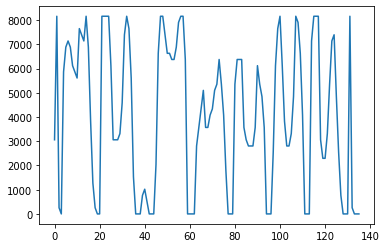

In [25]:
#字符分割
#根据设定的阈值和图片直方图，找出波峰，用于分隔字符
import numpy as np
import cv2
import matplotlib.pyplot as plt
def find_waves(threshold, histogram):
	up_point = -1#上升点
	is_peak = False
	if histogram[0] > threshold:
		up_point = 0
		is_peak = True
	wave_peaks = []
	for i,x in enumerate(histogram):
		if is_peak and x < threshold:
			if i - up_point > 2:
				is_peak = False
				wave_peaks.append((up_point, i))
		elif not is_peak and x >= threshold:
			is_peak = True
			up_point = i
	if is_peak and up_point != -1 and i - up_point > 4:
		wave_peaks.append((up_point, i))
	return wave_peaks

#根据找出的波峰，分隔图片，从而得到逐个字符图片
def seperate_card(img, waves):
	part_cards = []
	for wave in waves:
		part_cards.append(img[:, wave[0]:wave[1]])
	return part_cards


img = cv2.imread("./test/license-plate/170.jpg")
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, gray_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 查找水平直方图波峰
x_histogram = np.sum(gray_img, axis=1)
#plt.plot(x_histogram)
x_min = np.min(x_histogram)
x_average = np.sum(x_histogram)/x_histogram.shape[0]
x_threshold = (x_min + x_average)/2
wave_peaks = find_waves(x_threshold, x_histogram)
if len(wave_peaks) == 0:
    print("peak less 0:")
# 认为水平方向，最大的波峰为车牌区域
wave = max(wave_peaks, key=lambda x: x[1]-x[0])
gray_img = gray_img[wave[0]:wave[1]]
# 查找垂直直方图波峰
row_num, col_num = gray_img.shape[:2]
# 去掉车牌上下边缘1个像素，避免白边影响阈值判断
gray_img = gray_img[1:row_num-1]
y_histogram = np.sum(gray_img, axis=0)
plt.plot(y_histogram)
y_min = np.min(y_histogram)
y_average = np.sum(y_histogram)/y_histogram.shape[0]
y_threshold = (y_min + y_average)/5  # U和0要求阈值偏小，否则U和0会被分成两半

wave_peaks = find_waves(y_threshold, y_histogram)

# for wave in wave_peaks:
#	cv2.line(card_img, pt1=(wave[0], 5), pt2=(wave[1], 5), color=(0, 0, 255), thickness=2)
# 车牌字符数应大于6
if len(wave_peaks) <= 6:
    print("peak less 1:", len(wave_peaks))

wave = max(wave_peaks, key=lambda x: x[1]-x[0])
max_wave_dis = wave[1] - wave[0]
# 判断是否是左侧车牌边缘
if wave_peaks[0][1] - wave_peaks[0][0] < max_wave_dis/3 and wave_peaks[0][0] == 0:
    wave_peaks.pop(0)

# 组合分离汉字
cur_dis = 0
for i, wave in enumerate(wave_peaks):
    if wave[1] - wave[0] + cur_dis > max_wave_dis * 0.6:
        break
    else:
        cur_dis += wave[1] - wave[0]
if i > 0:
    wave = (wave_peaks[0][0], wave_peaks[i][1])
    wave_peaks = wave_peaks[i+1:]
    wave_peaks.insert(0, wave)

# 去除车牌上的分隔点
point = wave_peaks[2]
if point[1] - point[0] < max_wave_dis/3:
    point_img = gray_img[:, point[0]:point[1]]
    if np.mean(point_img) < 255/5:
        wave_peaks.pop(2)

if len(wave_peaks) <= 6:
    print("peak less 2:", len(wave_peaks))
part_cards = seperate_card(gray_img, wave_peaks)



In [39]:
for img in part_cards:
    cv2.imshow("img",img)
    cv2.waitKey(0)
cv2.waitKey(0)

-1

In [27]:
#进行预测
from  PIL import Image
predict_result = []

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,6,3)
        self.conv2 = nn.Conv2d(6,16,3)
        self.conv3 = nn.Conv2d(16,30,4)
        self.fnc1 = nn.Linear(144,100)
        self.fnc2 = nn.Linear(100,80)
        self.fnc3 = nn.Linear(80,65)
    def num_flat_features(self, x):
        size = x.size()[1:]  # 除去批处理维度的其他所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    def forward(self,x):
        x = F.relu(self.conv1(x)) #size (20-5+0)/1+1=16
        x = F.max_pool2d(x,(2,2)) 
        x = F.relu(self.conv2(x)) #size (28-5+0)/1+1 = 24
        x = F.max_pool2d(x,(2,2)) 
        #x = F.relu(self.conv3(x)) #size (24-5+0)/1+1 = 20
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fnc1(x))
        x = F.relu(self.fnc2(x))
        x = self.fnc3(x)
        return x


classes = os.listdir("./DataSet/cnn_char_train")
data_transform = transforms.Compose([
        #DanTongDao(),
        transforms.Resize((20,20)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, ],
                            std=[0.5,])
    ])
model1 = torch.load("./model/re_char.pth")
for i, part_card in enumerate(part_cards):
    # 可能是固定车牌的铆钉
    # cv2.imshow(str(i),part_card)
    # cv2.waitKey()
    if np.mean(part_card) < 255/5:
        print("a point")
        continue
    part_card_old = part_card
    # w = abs(part_card.shape[1] - SZ)//2

    # part_card = cv2.copyMakeBorder(
    #     part_card, 0, 0, w, w, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    # part_card = cv2.resize(
    #     part_card, (SZ, SZ), interpolation=cv2.INTER_AREA)

    # part_card = deskew(part_card)
    # part_card = preprocess_hog([part_card])
    # part_card = cv2.resize(part_card, (SZ, SZ), interpolation=cv2.INTER_AREA)
    # PIL_image = Image.fromarray(part_card) 
    
    # img = cv2.cvtColor(np.asarray(PIL_image),cv2.COLOR_RGB2BGR)
    #w = abs(img.shape[1] - 20)//2
    img = cv2.copyMakeBorder(part_card, 1, 1, 10, 10, cv2.BORDER_CONSTANT, value = [0,0,0])
    cv2.imshow("img"+str(i),img)
    #cv2.waitKey(0)
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #PIL_image = PIL_image.resize((20,20))
    PIL_image = Image.fromarray(img) 

    image = data_transform(PIL_image)
    image = image.reshape(1,1,20,20)
    with torch.no_grad():
        out = model1(image)
        _,predict = torch.max(out,1)
        charactor = classes[predict]
    # 判断最后一个数是否是车牌边缘，假设车牌边缘被认为是1
    if charactor == "1" and i == len(part_cards)-1:
        if part_card_old.shape[0]/part_card_old.shape[1] >= 7:  # 1太细，认为是边缘
            continue
    predict_result.append(charactor)
cv2.waitKey(0)


-1

In [28]:
print(predict_result)

['zh_wan', 'B', 'zh_yue', '9', '5', '8', 'K']


In [29]:
#建立测试集

#建立文件夹
paths = os.listdir("./DataSet/cnn_char_train")
classes = os.listdir("./DataSet/cnn_char_train")
for path in paths:
    path = os.path.join("./DataSet/cnn_char_test",path)
    if not os.path.exists(path):
        os.makedirs(path)
import shutil
#移动数据
for c in classes:
    for i in os.listdir("./DataSet/cnn_char_train/"+c)[:10]:
        shutil.move("./DataSet/cnn_char_train/"+c+"/"+i,"./DataSet/cnn_char_test/"+c+"/"+i)

In [30]:
class DanTongDao(object):
    def __call__(self, pics):
        pics = np.array(pics)
        #pics = cv2.resize(pics, (20, 20), interpolation=cv2.INTER_AREA)
        pics = cv2.cvtColor(pics,cv2.COLOR_BGR2GRAY)
        pics = cv2.copyMakeBorder(pics, 0, 0, 5, 5, cv2.BORDER_CONSTANT, value = [0,0,0])
        PIL_image = Image.fromarray(pics) 
        return PIL_image
    def __repr__(self):
        return self.__class__.__name__ + '()'

char_data_transform = {
    "train":
        transforms.Compose([
            DanTongDao(),
            transforms.Resize((20,20)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,],std=[0.5,])
        ]),
    "eval":
        transforms.Compose([
            DanTongDao(),
            transforms.Resize((20,20)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,],std=[0.5,])
        ])
}
    

char_train_dataset = datasets.ImageFolder(root='./DataSet/cnn_char_train',
                                           transform=char_data_transform['train'])
char_test_dataset = datasets.ImageFolder(root='./DataSet/cnn_char_test',
                                            transform=char_data_transform['eval'])

char_dataloader = {
    'train':torch.utils.data.DataLoader(char_train_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=0),
    'eval':torch.utils.data.DataLoader(char_test_dataset,
                                            batch_size=4,shuffle=True,
                                            num_workers=0)
}



In [31]:
#训练函数

def train_model(model,phases,criterion,optim,epochs,dataloader):
    train_acc_history = []
    val_acc_history = []
    best_accuracy = 0.0
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        for phase in phases:
            running_loss = 0.0
            running_corrects = 0.0
            if phase == 'train':
                model.train()
            elif phase == 'eval':
                model.eval()
            for i,data in enumerate(dataloader[phase]):
                X,y = data
                optim.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    out = model(X)
                    loss = criterion(out,y)
                    _,preds = torch.max(out,axis=1)
                    if phase=='train':
                        loss.backward()
                        optim.step()
                        #print("train labels:",y.data)
                        #print("preds labels:",out.data.numpy(),preds.data.numpy())
                    running_corrects += torch.sum(preds == y.data)
                    running_loss+=loss.item()*X.size(0)
            epoch_loss = running_loss/len(dataloader[phase].dataset)
            epoch_accuracy = running_corrects/len(dataloader[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))
            #print(str(epoch+1)+":\n"+phase+":"+"loss:%f ;  accuracy:%f" % (epoch_loss,epoch_accuracy))
            if phase == 'eval':
                val_acc_history.append(epoch_accuracy.numpy())
            if phase == 'train':
                train_acc_history.append(epoch_accuracy.numpy())
            if phase =='eval'and best_accuracy<epoch_accuracy:
                best_accuracy = epoch_accuracy
                torch.save(model,"./model/re_char.pth")
    return model,val_acc_history,train_acc_history

In [32]:

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

char_model,val_acc_history_char,train_acc_history = train_model(net,['train','eval'],criterion,optimizer,20,char_dataloader)

Epoch 0/19
----------
train Loss: 2.0929 Acc: 0.4776
eval Loss: 2.6630 Acc: 0.4163
Epoch 1/19
----------
train Loss: 0.5429 Acc: 0.8458
eval Loss: 2.0667 Acc: 0.6163
Epoch 2/19
----------
train Loss: 0.3321 Acc: 0.9009
eval Loss: 1.8359 Acc: 0.6821
Epoch 3/19
----------
train Loss: 0.2508 Acc: 0.9233
eval Loss: 1.6899 Acc: 0.7175
Epoch 4/19
----------
train Loss: 0.2021 Acc: 0.9387
eval Loss: 1.6317 Acc: 0.7490
Epoch 5/19
----------
train Loss: 0.1643 Acc: 0.9512
eval Loss: 1.6071 Acc: 0.7641
Epoch 6/19
----------
train Loss: 0.1325 Acc: 0.9605
eval Loss: 1.6784 Acc: 0.7514
Epoch 7/19
----------
train Loss: 0.1155 Acc: 0.9642
eval Loss: 1.5796 Acc: 0.7849
Epoch 8/19
----------
train Loss: 0.0976 Acc: 0.9702
eval Loss: 1.6430 Acc: 0.7801
Epoch 9/19
----------
train Loss: 0.0836 Acc: 0.9740
eval Loss: 1.5526 Acc: 0.8060
Epoch 10/19
----------
train Loss: 0.0759 Acc: 0.9767
eval Loss: 1.6079 Acc: 0.8028
Epoch 11/19
----------
train Loss: 0.0680 Acc: 0.9779
eval Loss: 1.6342 Acc: 0.8100
Ep

In [33]:
print(list(np.array(val_acc_history_char)),list(np.array(train_acc_history)))

[0.41633466, 0.6163347, 0.6820717, 0.7175299, 0.749004, 0.7641434, 0.75139445, 0.78486055, 0.78007966, 0.8059761, 0.80278885, 0.8099602, 0.8199203, 0.8051793, 0.823506, 0.8286853, 0.82669324, 0.82310754, 0.825498, 0.838247] [0.4775627, 0.8457985, 0.90086526, 0.92330253, 0.9387007, 0.95116585, 0.96047807, 0.9642176, 0.9702302, 0.9739698, 0.9766828, 0.977856, 0.9829887, 0.9828421, 0.98555505, 0.98606837, 0.98687494, 0.98790145, 0.98995453, 0.9903945]


[0.9112903475761414, 0.9516128897666931, 0.9677419066429138, 0.975806474685669, 0.9677419066429138, 0.9596773982048035, 0.9516128897666931, 0.9677419066429138, 0.9596773982048035, 0.9596773982048035]
[0.47756269574165344, 0.8457984924316406, 0.9008652567863464, 0.9233025312423706, 0.9387006759643555, 0.9511658549308777, 0.9604780673980713, 0.9642176032066345, 0.970230221748352, 0.9739698171615601, 0.9766827821731567, 0.9778559803962708, 0.982988715171814, 0.9828420877456665, 0.9855550527572632, 0.9860683679580688, 0.9868749380111694, 0.9879014492034912, 0.9899545311927795, 0.9903944730758667]


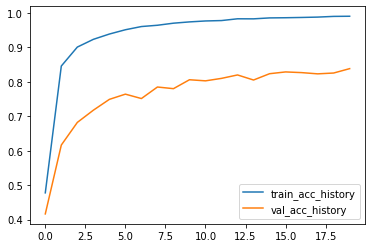

In [34]:
val_acc_history_char = list(np.array(val_acc_history_char).astype(np.float))
print(val_acc_history)
train_acc_history = list(np.array(train_acc_history).astype(np.float))
print(train_acc_history)

plt.plot(train_acc_history,label='train_acc_history')
plt.plot(val_acc_history_char,label='val_acc_history')
plt.legend()